# Model Training
---

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import sys
sys.path.append('../scripts')
from data_utils import labels, view_img, calculate_featuremap_size, maxpool2d_size

import warnings
warnings.filterwarnings("ignore")

In [9]:
# import data

# CNN data
test_cnn_X = pd.read_csv('../data/labels/test_cnn_X.csv', index_col=0)
test_cnn_y = pd.read_csv('../data/labels/test_cnn_y.csv', index_col=0)

train_cnn_X = pd.read_csv('../data/labels/train_cnn_X.csv', index_col=0)
train_cnn_y = pd.read_csv('../data/labels/train_cnn_y.csv', index_col=0)

val_cnn_X = pd.read_csv('../data/labels/val_cnn_X.csv', index_col=0)
val_cnn_y = pd.read_csv('../data/labels/val_cnn_y.csv', index_col=0)


# Tabular data
test_tab_X = pd.read_csv('../data/labels/test_tab_X.csv', index_col=0)
test_tab_y = pd.read_csv('../data/labels/test_tab_y.csv', index_col=0)

train_tab_X = pd.read_csv('../data/labels/train_tab_X.csv', index_col=0)
train_tab_y = pd.read_csv('../data/labels/train_tab_y.csv', index_col=0)

val_tab_X = pd.read_csv('../data/labels/val_tab_X.csv', index_col=0)
val_tab_y = pd.read_csv('../data/labels/val_tab_y.csv', index_col=0)

# MLP Model

In [10]:
# Convert data to torch.float32

def convert_to_float32(data):
    return torch.tensor(data.values, dtype=torch.float32)

# Convert Tabular data
test_tab_X = convert_to_float32(test_tab_X)
test_tab_y = convert_to_float32(test_tab_y)

train_tab_X = convert_to_float32(train_tab_X)
train_tab_y = convert_to_float32(train_tab_y)

val_tab_X = convert_to_float32(val_tab_X)
val_tab_y = convert_to_float32(val_tab_y)

In [11]:
# Developed a multi-label classification multi-lablel perceptron for tabular data

class MLP(nn.Module):
    def __init__(self, in_features=4, hidden1=64, hidden2=32, out_features=15):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden1)

        self.fc2 = nn.Linear(in_features=hidden1, out_features=hidden2)

        self.output = nn.Linear(in_features=hidden2, out_features=out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        
        return x

model = MLP()

In [12]:
# Identified label imbalance among target variables

label_counts = train_tab_y.sum(dim=0)
print(label_counts)

tensor([ 6631.,  1381.,  2298.,  1136.,  6937.,  1161.,  1015.,   109., 11052.,
         3230., 40458.,  3841.,  1792.,   675.,  2117.])


In [13]:
# Select loss function and optimizer

num_samples = train_tab_y.shape[0]
neg_counts = num_samples - label_counts
pos_weight = neg_counts / (label_counts + 1e-8)  


criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [14]:
# Model training

epoch = 100
losses = []

for i in range(epoch):

    y_pred = model(train_tab_X)

    loss = criterion(y_pred, train_tab_y)

    losses.append(loss.detach().numpy())

    if i % 10 == 0:
        print(f'Epoch: {i}, loss: {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch: 0, loss: 1.2822998762130737
Epoch: 10, loss: 1.2030202150344849
Epoch: 20, loss: 1.1843101978302002
Epoch: 30, loss: 1.1768851280212402
Epoch: 40, loss: 1.1717830896377563
Epoch: 50, loss: 1.1673753261566162
Epoch: 60, loss: 1.1641709804534912
Epoch: 70, loss: 1.1636629104614258
Epoch: 80, loss: 1.1597143411636353
Epoch: 90, loss: 1.1598345041275024


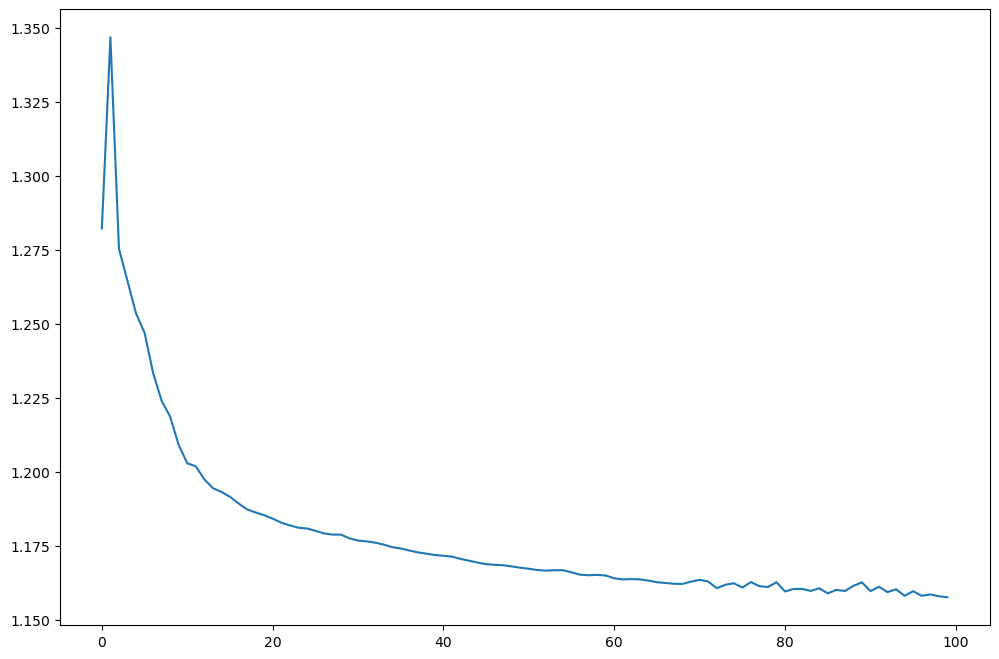

In [15]:
plt.figure(figsize=(12,8))
plt.plot(range(epoch), losses)
plt.show()

# Custom CNN Model

In [16]:

# images need to be converted to float32, issue: current X represent file path to images not images themselves
# use ToTensor dugin transformation
""" 
# Convert CNN data
test_cnn_X = convert_to_float32(test_cnn_X)
test_cnn_y = convert_to_float32(test_cnn_y)

train_cnn_X = convert_to_float32(train_cnn_X)
train_cnn_y = convert_to_float32(train_cnn_y)

val_cnn_X = convert_to_float32(val_cnn_X)
val_cnn_y = convert_to_float32(val_cnn_y)
"""



' \n# Convert CNN data\ntest_cnn_X = convert_to_float32(test_cnn_X)\ntest_cnn_y = convert_to_float32(test_cnn_y)\n\ntrain_cnn_X = convert_to_float32(train_cnn_X)\ntrain_cnn_y = convert_to_float32(train_cnn_y)\n\nval_cnn_X = convert_to_float32(val_cnn_X)\nval_cnn_y = convert_to_float32(val_cnn_y)\n'

In [17]:
# Convert labels to float32
"""
test_cnn_y = convert_to_float32(test_cnn_y)
train_cnn_y = convert_to_float32(train_cnn_y)
val_cnn_y = convert_to_float32(val_cnn_y)
"""

'\ntest_cnn_y = convert_to_float32(test_cnn_y)\ntrain_cnn_y = convert_to_float32(train_cnn_y)\nval_cnn_y = convert_to_float32(val_cnn_y)\n'

In [18]:
# Initialize CNN Dataset and DataLoader

class CNNDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        img_path = self.X.iloc[idx]["image_path"]
        img = Image.open(img_path).convert('L')
        label = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label
    
# Apply transformations: convert to tensor, resize to 224x224
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

# Initialize datasets
test_dataset = CNNDataset(X=test_cnn_X, y=test_cnn_y, transform=transform)
train_dataset = CNNDataset(X=train_cnn_X, y=train_cnn_y, transform=transform)
val_dataset = CNNDataset(X=val_cnn_X, y=val_cnn_y, transform=transform)

# Initialize loaders
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

In [19]:
calculate_featuremap_size(14, 0, 1, 3)

12

In [20]:
maxpool2d_size(12, 0, 2, 2)

6

In [21]:
# Create CNN architecture

# shape (64,64)
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3) # 64 x 62 x62
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2,2) # 64 x 31 x 31

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3) # 32 x 29 x 29
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,2) # 32 x 14 x 14

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3) # 16 x 12 x 12
        self.bn3 = nn.BatchNorm2d(16)
        self.pool3 = nn.MaxPool2d(2,2) # 16 x 6 x 6

        self.fc1 = nn.Linear(in_features= 16 * 6 * 6, out_features=32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=32, out_features=15)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()

In [22]:
# shape (128,128)
"""
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3) # 64 x 126 x 126
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2,2) # 64 x 63 x 63

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3) # 32 x 61 x 61
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,2) # 32 x 30 x 30

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3) # 16 x 28 x 28
        self.bn3 = nn.BatchNorm2d(16)
        self.pool3 = nn.MaxPool2d(2,2) # 16 x 14 x 14

        self.fc1 = nn.Linear(in_features= 16 * 14 * 14, out_features=32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=32, out_features=15)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()
"""

'\nclass CNN(nn.Module):\n\n    def __init__(self):\n        super().__init__()\n\n        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3) # 64 x 126 x 126\n        self.bn1 = nn.BatchNorm2d(64)\n        self.pool1 = nn.MaxPool2d(2,2) # 64 x 63 x 63\n\n        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3) # 32 x 61 x 61\n        self.bn2 = nn.BatchNorm2d(32)\n        self.pool2 = nn.MaxPool2d(2,2) # 32 x 30 x 30\n\n        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3) # 16 x 28 x 28\n        self.bn3 = nn.BatchNorm2d(16)\n        self.pool3 = nn.MaxPool2d(2,2) # 16 x 14 x 14\n\n        self.fc1 = nn.Linear(in_features= 16 * 14 * 14, out_features=32)\n        self.dropout = nn.Dropout(0.5)\n        self.fc2 = nn.Linear(in_features=32, out_features=15)\n\n    def forward(self, x):\n        x = self.pool1(F.relu(self.bn1(self.conv1(x))))\n        x = self.pool2(F.relu(self.bn2(self.conv2(x))))\n        x = self.pool3(

In [23]:
# imbalance label classes
train_cnn_y.sum().values

array([ 6631,  1381,  2298,  1136,  6937,  1161,  1015,   109, 11052,
        3230, 40458,  3841,  1792,   675,  2117], dtype=int64)

In [24]:
# prepare BCEWithLogitLoss

label_counts = train_cnn_y.sum().values
total_samples = train_cnn_y.shape[0]

pos_weight = (total_samples - label_counts) / label_counts
pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

In [25]:
print("PyTorch CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


PyTorch CUDA version: 11.8
CUDA available: True
Device count: 1
Device name: NVIDIA GeForce RTX 3070


In [26]:

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [ ]:
# Model Training

"""
num_epoch = 1

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0

    for i, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 2 == 0:
            print(f'Epoch: {i+1}, loss: {loss.item():.4f}')

avg_loss = running_loss / len(train_loader)
print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {avg_loss:.4f}")

"""

# ResNet Model

# DenseNet Model